In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.preprocessing as preprocess
from collections import Counter
import pprint
from scipy.stats import chisquare
from sklearn.decomposition import PCA
import seaborn as sns

pp = pprint.PrettyPrinter(indent=4)

## Reorganize data

In [13]:
#unique songs df, drop categorical features
unique_df = pd.read_csv("TopCharts_unique.csv", index_col = 0).drop(columns = ["Instrumentalness", "Time Signature", "Key", "Mode"])

In [14]:
unique_df.columns

Index(['Artist', 'Title', 'Id', 'Tempo', 'Valence', 'Danceability', 'Energy',
       'Acousticness', 'Days'],
      dtype='object')

In [15]:
cont_cols = list(unique_df.columns[3:8])

In [16]:
#get 25th, 50th, 75th quantiles of continuous features for each artist 
cols = ["Artist", "Total_Days"]
qs = ["q25", "q50", "q75"]
for c in cont_cols:
    cols.extend([q + c for q in qs])
d = {c:[] for c in cols}

for a in unique_df.Artist.unique():
    s = unique_df.loc[unique_df.Artist == a, :]
    d["Total_Days"].append(s.Days.sum())
    
    sub = s.loc[unique_df.Artist == a, cont_cols]
    d["Artist"].append(a)
    for q in qs:
        quant = int(q[1:])
        data = dict(sub.quantile(q = quant/100))
        for k in data.keys():
            d[q+k].append(data[k])

In [17]:
artist_df = pd.DataFrame(d)

In [18]:
artist_df.head()

,Artist,Total_Days,q25Tempo,q50Tempo,q75Tempo,q25Valence,q50Valence,q75Valence,q25Danceability,q50Danceability,q75Danceability,q25Energy,q50Energy,q75Energy,q25Acousticness,q50Acousticness,q75Acousticness
0,Post Malone,8033,101.23675,133.0240,149.06250,0.23200,0.324,0.45725,0.57050,0.6310,0.71675,0.55225,0.6495,0.73375,0.124000,0.20650,0.41075
1,G-Eazy,539,97.95300,100.0130,160.01400,0.26100,0.645,0.70400,0.58900,0.8170,0.83900,0.70500,0.7430,0.77100,0.011700,0.05340,0.07380
2,Lil Pump,396,125.02000,139.9770,148.03500,0.45750,0.549,0.69500,0.87400,0.9250,0.93500,0.48400,0.5050,0.56000,0.009485,0.02290,0.14295
3,Cardi B,2041,128.73825,133.9875,141.58100,0.26175,0.454,0.56375,0.80225,0.8605,0.91250,0.53850,0.5700,0.64450,0.028150,0.06505,0.11875
4,Camila Cabello,974,94.66425,104.9880,120.56175,0.27225,0.394,0.55075,0.56350,0.6755,0.73550,0.49625,0.5355,0.66250,0.151750,0.19700,0.41575


In [19]:
# artist_df.to_csv("ArtistData.csv")

## K-means clustering (PCA)

In [20]:
#clustering on these features
cluster_cols = artist_df.columns[2:]

In [21]:
cluster_cols

Index(['q25Tempo', 'q50Tempo', 'q75Tempo', 'q25Valence', 'q50Valence',
       'q75Valence', 'q25Danceability', 'q50Danceability', 'q75Danceability',
       'q25Energy', 'q50Energy', 'q75Energy', 'q25Acousticness',
       'q50Acousticness', 'q75Acousticness'],
      dtype='object')

In [22]:
def scaleData(scaler, df, col_list = cluster_cols):
    
    """
    normalizes continuous values in dataframe
    
    inputs:  scaler:    one of the scaler functions from sklearn.preprocessing
             song_df:   dataframe of songs (with titles) 
             firstCol:  index of first column of continuous values to be rescaled in song_df 
    
    returns: dataframe of songs (with titles) with rescaled continuous values
    """
    
    scaled_df = df.copy()
        
    cluster_values = df.loc[:,col_list]
    mms = scaler()
    scaled_values = mms.fit_transform(cluster_values)
    
    for i in range(scaled_values.shape[1]):
        scaled_df[col_list[i]] = scaled_values[:,i]

    return scaled_df

In [23]:
scaled_df = scaleData(preprocess.MinMaxScaler, artist_df)

In [24]:
scaled_df.head()

,Artist,Total_Days,q25Tempo,q50Tempo,q75Tempo,q25Valence,q50Valence,q75Valence,q25Danceability,q50Danceability,q75Danceability,q25Energy,q50Energy,q75Energy,q25Acousticness,q50Acousticness,q75Acousticness
0,Post Malone,8033,0.355808,0.563263,0.653745,0.184208,0.280623,0.426746,0.504258,0.577859,0.682178,0.534492,0.641832,0.734823,0.124716,0.207632,0.413145
1,G-Eazy,539,0.334378,0.347822,0.723700,0.215836,0.632635,0.697335,0.526764,0.804136,0.830900,0.703091,0.745033,0.775938,0.011733,0.053586,0.074112
2,Lil Pump,396,0.511026,0.608641,0.647182,0.430145,0.527360,0.687466,0.873479,0.935523,0.947689,0.459161,0.482340,0.543046,0.009505,0.022898,0.143690
3,Cardi B,2041,0.535293,0.569551,0.605956,0.216654,0.423182,0.543535,0.786192,0.857056,0.920316,0.519316,0.554084,0.636313,0.028283,0.065308,0.119340
4,Camila Cabello,974,0.312914,0.380290,0.471691,0.228106,0.357386,0.529280,0.495742,0.631995,0.704988,0.472682,0.516004,0.656181,0.152634,0.198074,0.418176


In [25]:
def apply_pca(scaled_df, n, col_list = cluster_cols):
    """
    applies PCA to dataframe and attaches resulting PCA values as columns to end of dataframe
    
    inputs:  scaled_df:  dataframe of songs (with titles) with scaled continuous values
             n:          number of desired principal components
             firstCol:   index of first column of continuous values
             
    returns: scaled_df with principal component columns appended to end 
    """  
    
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(scaled_df.loc[:,col_list])
    pca_df = scaled_df.copy()
    for i in range(n):
        pca_df[f"pc{i+1}"] = principalComponents[:,i]
        
    return pca_df
    

In [26]:
pca_df = apply_pca(scaled_df, 2)

In [27]:
def plotKMeans(scaled_df, minCluster, maxCluster, col_list):
    """
    applies k-means clustering to dataframe and plots inertia and change in inertia for corresponding to number of clusters
    
    inputs:   df:          dataframe with only continuous values
              minCluster:  smallest number of desired clusters
              maxClusters: largest number of desired clusters
              col_list:    columns to cluster on
    
    returns:  list of intertias corresponding to number of clusters ranging from minCluster to maxCluster
    
    """

    df = scaled_df.loc[:,col_list]
    
    
    inertias = []
    for i in range(minCluster, maxCluster+1):
        kmeans = KMeans(n_clusters = i).fit(df)
        inertias.append(kmeans.inertia_)    
    
    plt.plot(range(1,len(inertias)+1), inertias, "bx-")
    plt.xlabel('k')
    plt.ylabel("Inertia")
    plt.xticks(range(1,len(inertias)+1))
    plt.show()
    
    
    diffs = np.array(inertias[1:]) - np.array(inertias[:len(inertias)-1])
    plt.plot(range(1,len(inertias)+1), [-inertias[0]] + list(diffs),"bx-")
    plt.ylabel("Change in Inertia")
    plt.xticks(range(1,len(inertias)+1))

    plt.show()
    
    return inertias

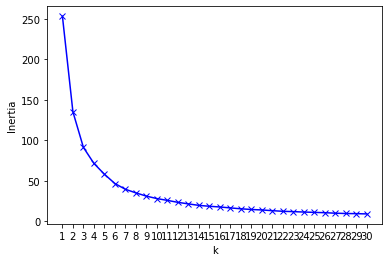

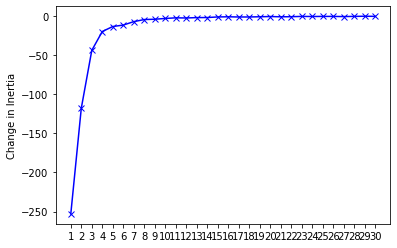

In [28]:
inertias = plotKMeans(pca_df, 1, 30, ["pc1", "pc2"])

In [29]:
k = 8

In [30]:
def sort_df(df, k):
    df = df.sort_values(by = "Label").reset_index(drop = True)

    for i in range(k):
        sub = df.loc[df.Label == i]
        first = sub.index[0]
        last = sub.index[-1]+1
        df.iloc[first:last, :] = sub.sort_values(by = "Total_Days", ascending = False).values
    
    return df.reset_index(drop = True)

In [31]:
def fitKMeans(scaled_df, k, col_list):
    """
    applies k-means clustering with k clusters to dataframe
    
    inputs:   song_df:      dataframe of songs (with titles)
              clusters:  number of desired clusters
              col_list: list of column indexes to cluster on
            
    returns:  dataframe of songs with cluster number
              dict of dataframes {cluster number: subset of song_df with songs belonging to cluster}
              dict of Counters   {cluster number: Counter(artist, number of times artist appears in cluster)}
    """
    
    kmeans_opt = KMeans(n_clusters = k).fit(scaled_df.loc[:,col_list])
    labels_df = scaled_df.copy()
    labels_df["Label"] = kmeans_opt.labels_
    
    return sort_df(labels_df, k)

In [32]:
cluster_df = fitKMeans(pca_df, k, ["pc1", "pc2"])

In [33]:
cluster_df

,Artist,Total_Days,q25Tempo,q50Tempo,q75Tempo,q25Valence,q50Valence,q75Valence,q25Danceability,q50Danceability,q75Danceability,q25Energy,q50Energy,q75Energy,q25Acousticness,q50Acousticness,q75Acousticness,pc1,pc2,Label
0,DaBaby,1236,0.335955,0.553160,0.695741,0.592649,0.711591,0.842636,0.745438,0.815085,0.878345,0.646247,0.673841,0.753035,0.023731,0.058215,0.117328,-0.525692,0.288931,0
1,Famous Dex,664,0.384993,0.582653,0.697996,0.546297,0.847571,0.860182,0.669708,0.701946,0.816302,0.556843,0.673289,0.703091,0.068325,0.121604,0.178956,-0.389253,0.351805,0
2,BlocBoy JB,522,0.609046,0.609156,0.596323,0.637638,0.693497,0.751343,0.924574,0.927007,0.929440,0.621413,0.676600,0.731788,0.048284,0.095463,0.142744,-0.534393,0.320777,0
3,Flipp Dinero,462,0.527026,0.576087,0.611868,0.758425,0.775195,0.793289,0.784063,0.794404,0.804745,0.655629,0.685430,0.715232,0.103840,0.105002,0.106260,-0.498735,0.420378,0
4,Bruno Mars,298,0.387172,0.393226,0.471412,0.744792,0.868407,0.904595,0.736010,0.805353,0.826642,0.677152,0.811258,0.842163,0.015808,0.018470,0.026268,-0.693674,0.473261,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,Corey,1,0.235020,0.235020,0.230027,0.208202,0.203860,0.203860,0.351582,0.351582,0.351582,0.412804,0.412804,0.412804,0.766591,0.766566,0.766566,1.151747,-0.123050,7
626,Norah Jones,1,0.316182,0.316182,0.309465,0.221289,0.217019,0.217019,0.388078,0.388078,0.388078,0.000000,0.000000,0.000000,0.898387,0.898376,0.898376,1.643940,-0.020863,7
627,Joni Mitchell,1,0.095428,0.095428,0.093401,0.348893,0.345323,0.345323,0.302920,0.302920,0.302920,0.092715,0.092715,0.092715,0.984909,0.984907,0.984907,1.694320,0.237337,7
628,Calum Scott,1,0.812622,0.812622,0.795357,0.168939,0.164382,0.164382,0.212895,0.212895,0.212895,0.184327,0.184327,0.184327,0.923538,0.923530,0.923530,1.561085,-0.192962,7


In [34]:
def getCluster(cluster_df, cluster_idx, top = -1):
    artists = list(cluster_df[cluster_df.Label == cluster_idx].Artist)
    if top == -1:
        return {cluster_idx: artists}
    else:
        return {cluster_idx: artists[:min(top, len(artists))]}

In [111]:
for i in range(k):
    pp.pprint(getCluster(cluster_df, i, top = 4))

{0: ['XXXTENTACION', 'Billie Eilish', 'Sam Smith', 'Joji']}
{1: ['DaBaby', 'Famous Dex', 'BlocBoy JB', 'Flipp Dinero']}
{2: ['Khalid', 'Drake', 'Ariana Grande', 'Trippie Redd']}
{3: ['Cardi B', 'Lil Uzi Vert', 'Lil Skies', 'Marshmello']}
{4: ['Dean Lewis', 'Lil Dicky', 'TOTO', 'Brenda Lee']}
{5: ['Bing Crosby', 'Old Dominion', 'Alec Benjamin', 'Frank Sinatra']}
{6: ['Post Malone', 'Juice WRLD', 'Travis Scott', 'Lil Baby']}
{7: ['Lewis Capaldi', 'Lana Del Rey', 'Idina Menzel', 'Judy Garland']}


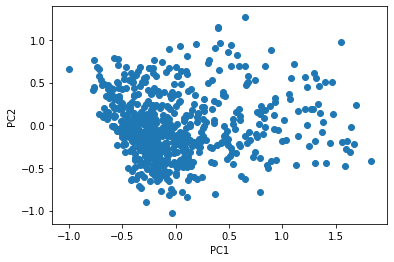

In [44]:
plt.scatter(cluster_df["pc1"], cluster_df["pc2"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

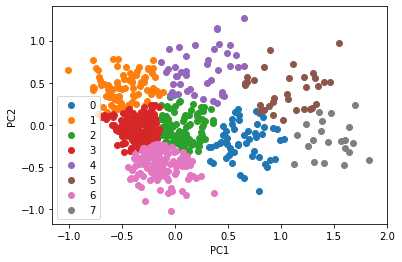

In [45]:
for i in range(k):
    sub = cluster_df.loc[cluster_df.Label == i,:]
    plt.scatter(sub["pc1"], sub["pc2"], label = i)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

## Un-scale features

In [46]:
artist_df

,Artist,Total_Days,q25Tempo,q50Tempo,q75Tempo,q25Valence,q50Valence,q75Valence,q25Danceability,q50Danceability,q75Danceability,q25Energy,q50Energy,q75Energy,q25Acousticness,q50Acousticness,q75Acousticness
0,Post Malone,8033,101.23675,133.0240,149.06250,0.23200,0.324,0.45725,0.57050,0.6310,0.71675,0.55225,0.6495,0.73375,0.124000,0.20650,0.41075
1,G-Eazy,539,97.95300,100.0130,160.01400,0.26100,0.645,0.70400,0.58900,0.8170,0.83900,0.70500,0.7430,0.77100,0.011700,0.05340,0.07380
2,Lil Pump,396,125.02000,139.9770,148.03500,0.45750,0.549,0.69500,0.87400,0.9250,0.93500,0.48400,0.5050,0.56000,0.009485,0.02290,0.14295
3,Cardi B,2041,128.73825,133.9875,141.58100,0.26175,0.454,0.56375,0.80225,0.8605,0.91250,0.53850,0.5700,0.64450,0.028150,0.06505,0.11875
4,Camila Cabello,974,94.66425,104.9880,120.56175,0.27225,0.394,0.55075,0.56350,0.6755,0.73550,0.49625,0.5355,0.66250,0.151750,0.19700,0.41575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,Matthew Wilder,14,110.07700,110.0770,110.07700,0.82800,0.828,0.82800,0.91700,0.9170,0.91700,0.58800,0.5880,0.58800,0.195000,0.19500,0.19500
626,Surfaces,12,112.02200,112.0220,112.02200,0.69400,0.694,0.69400,0.87800,0.8780,0.87800,0.52500,0.5250,0.52500,0.183000,0.18300,0.18300
627,K CAMP,3,148.96400,148.9640,148.96400,0.67000,0.670,0.67000,0.91500,0.9150,0.91500,0.55600,0.5560,0.55600,0.014500,0.01450,0.01450
628,Hayley Williams,2,109.97000,109.9700,109.97000,0.36200,0.362,0.36200,0.78100,0.7810,0.78100,0.59800,0.5980,0.59800,0.213000,0.21300,0.21300


In [47]:
label_artist_df = artist_df.copy()
for i in range(len(cluster_df)):
    row = cluster_df.loc[i,:]
    label_artist_df.loc[label_artist_df.Artist == row["Artist"], "Label"] = int(row["Label"])
    label_artist_df.loc[label_artist_df.Artist == row["Artist"], "pc1"] = row["pc1"]
    label_artist_df.loc[label_artist_df.Artist == row["Artist"], "pc2"] = row["pc2"]
label_artist_df = sort_df(label_artist_df, k)

In [48]:
label_artist_df.head()

,Artist,Total_Days,q25Tempo,q50Tempo,q75Tempo,q25Valence,q50Valence,q75Valence,q25Danceability,q50Danceability,q75Danceability,q25Energy,q50Energy,q75Energy,q25Acousticness,q50Acousticness,q75Acousticness,Label,pc1,pc2
0,XXXTENTACION,5948,89.42450,127.0800,137.80100,0.220,0.4050,0.5625,0.58100,0.7270,0.79700,0.3100,0.4810,0.57500,0.13950,0.461,0.75250,0.0,0.479702,-0.072177
1,Billie Eilish,4240,100.00650,120.0130,135.70750,0.120,0.2160,0.4215,0.48850,0.6855,0.72825,0.2325,0.3415,0.42225,0.44250,0.732,0.90625,0.0,1.031927,-0.173290
2,Sam Smith,748,86.87425,97.4355,111.70625,0.238,0.3425,0.3455,0.46725,0.5595,0.69050,0.3795,0.4135,0.56050,0.24975,0.463,0.60100,0.0,0.599869,-0.240148
3,Joji,600,84.85100,99.2840,129.91400,0.196,0.2900,0.4250,0.44000,0.6460,0.71600,0.3770,0.5150,0.59600,0.34700,0.618,0.71000,0.0,0.701228,-0.173108
4,Metro Boomin,590,88.03100,117.1570,129.21600,0.196,0.3910,0.4950,0.63800,0.7320,0.81000,0.3530,0.4640,0.50100,0.25700,0.413,0.58800,0.0,0.453271,-0.124324


In [41]:
# label_artist_df.to_csv("ArtistData_clustered_pca.csv")

In [66]:
medians = ["q50Tempo", "q50Valence", "q50Danceability", "q50Energy", "q50Acousticness"]
avg_df = pd.DataFrame(columns = medians)
for i in range(k):
    for m in medians:
        avg_df.loc[i,m] = cluster_df.loc[cluster_df.Label == i, m].mean()

In [67]:
avg_df

,q50Tempo,q50Valence,q50Danceability,q50Energy,q50Acousticness
0,0.453899,0.267761,0.482957,0.45895,0.499662
1,0.485305,0.787085,0.730228,0.732371,0.125033
2,0.444393,0.448366,0.622967,0.588743,0.251409
3,0.488678,0.517619,0.66258,0.717066,0.0788166
4,0.500213,0.770434,0.611189,0.598548,0.51876
5,0.402231,0.521638,0.519826,0.306388,0.813935
6,0.520385,0.247631,0.603024,0.641969,0.0777342
7,0.444104,0.164398,0.279429,0.207537,0.852858


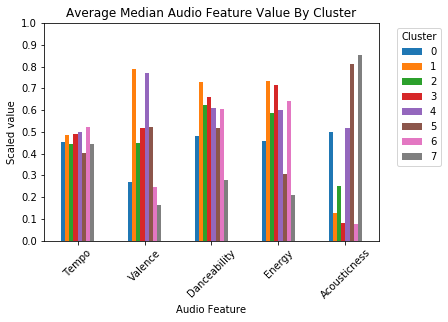

In [110]:
avg_df.T.plot.bar(yticks = np.arange(0,1.1,.1), rot = 45, legend = False)
plt.xlabel("Audio Feature")
plt.xticks(ticks = range(5), labels = ["Tempo", "Valence", "Danceability", "Energy", "Acousticness"])
plt.ylabel("Scaled value")
plt.title("Average Median Audio Feature Value By Cluster")
plt.legend(range(k), bbox_to_anchor=(1.2, 1.0), title = "Cluster")
plt.show()